<a href="https://www.kaggle.com/code/azizbekboboqulov/predicting-airline-passenger-satisfaction?scriptVersionId=135560845" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aviakompaniya/sample_submission.csv
/kaggle/input/aviakompaniya/train_dataset.csv
/kaggle/input/aviakompaniya/test_dataset.csv


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Dataset

In [3]:
df=pd.read_csv("/kaggle/input/aviakompaniya/train_dataset.csv", index_col=0)
df.head()

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
id,,,,,,,,,,,,,,,,,,,,,
1,Male,disloyal Customer,33,Business travel,Eco,571,2,3,2,4,...,4,3,1,3,4,3,4,10,3.0,0
2,Female,Loyal Customer,49,Business travel,Business,1431,4,1,4,4,...,5,5,5,5,3,5,3,0,0.0,1
3,Female,Loyal Customer,43,Business travel,Eco,867,1,4,4,4,...,1,1,1,1,1,1,2,0,18.0,0
4,Female,Loyal Customer,27,Business travel,Business,1550,3,3,3,3,...,2,4,4,5,5,4,2,0,0.0,1
5,Male,Loyal Customer,11,Personal Travel,Eco,526,3,4,3,2,...,4,5,2,5,3,5,4,0,10.0,0


## Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             10000 non-null  object 
 1   Customer Type                      10000 non-null  object 
 2   Age                                10000 non-null  int64  
 3   Type of Travel                     10000 non-null  object 
 4   Class                              10000 non-null  object 
 5   Flight Distance                    10000 non-null  int64  
 6   Inflight wifi service              10000 non-null  int64  
 7   Departure/Arrival time convenient  10000 non-null  int64  
 8   Ease of Online booking             10000 non-null  int64  
 9   Gate location                      10000 non-null  int64  
 10  Food and drink                     10000 non-null  int64  
 11  Online boarding                    10000 non-null  int

In [5]:
df['Arrival Delay in Minutes'].isnull().sum()

28

In [6]:
df=df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1 to 10000
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             10000 non-null  object 
 1   Customer Type                      10000 non-null  object 
 2   Age                                10000 non-null  int64  
 3   Type of Travel                     10000 non-null  object 
 4   Class                              10000 non-null  object 
 5   Flight Distance                    10000 non-null  int64  
 6   Inflight wifi service              10000 non-null  int64  
 7   Departure/Arrival time convenient  10000 non-null  int64  
 8   Ease of Online booking             10000 non-null  int64  
 9   Gate location                      10000 non-null  int64  
 10  Food and drink                     10000 non-null  int64  
 11  Online boarding                    10000 non-null  int

In [7]:
df.describe()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,39.375100,1229.556200,2.780200,3.065100,2.797800,2.981000,3.214500,3.349100,3.49140,3.402900,3.454100,3.415700,3.676200,3.360600,3.680100,3.311100,14.429900,14.668700,0.500000
std,14.897959,1022.281958,1.362745,1.527316,1.421168,1.283278,1.333217,1.352779,1.31122,1.331822,1.274777,1.308765,1.189746,1.258462,1.175118,1.311217,39.659674,39.997799,0.500025
min,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,27.000000,421.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.00000,2.000000,3.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000
50%,40.000000,863.500000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.00000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.500000
75%,51.000000,1806.750000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.00000,5.000000,4.000000,5.000000,5.000000,4.000000,5.000000,4.000000,12.000000,12.000000,1.000000
max,80.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,921.000000,924.000000,1.000000


In [8]:
df['satisfaction'].value_counts()

0    5000
1    5000
Name: satisfaction, dtype: int64

In [9]:
df.corrwith(df['satisfaction']).abs().sort_values(ascending=False)

/tmp/ipykernel_20/1954633012.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corrwith(df['satisfaction']).abs().sort_values(ascending=False)


satisfaction                         1.000000
Online boarding                      0.504986
Inflight entertainment               0.400900
Seat comfort                         0.342294
On-board service                     0.326426
Leg room service                     0.324368
Cleanliness                          0.310338
Flight Distance                      0.298703
Inflight wifi service                0.277395
Baggage handling                     0.247965
Inflight service                     0.240584
Checkin service                      0.232359
Food and drink                       0.207854
Ease of Online booking               0.164662
Age                                  0.144302
Departure/Arrival time convenient    0.067638
Arrival Delay in Minutes             0.048573
Departure Delay in Minutes           0.042960
Gate location                        0.007169
dtype: float64

## Preparation for ML

In [10]:
encoded = pd.get_dummies(df)
encoded.head()

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,satisfaction,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
1,33,571,2,3,2,4,4,2,4,4,...,0,0,1,0,1,1,0,0,1,0
2,49,1431,4,1,4,4,3,5,4,5,...,1,1,0,1,0,1,0,1,0,0
3,43,867,1,4,4,4,4,4,3,1,...,0,1,0,1,0,1,0,0,1,0
4,27,1550,3,3,3,3,2,2,2,2,...,1,1,0,1,0,1,0,1,0,0
5,11,526,3,4,3,2,4,3,4,4,...,0,0,1,1,0,0,1,0,1,0


In [11]:
X = encoded.drop("satisfaction", axis=1)
y = encoded['satisfaction']

In [12]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

## ML
### XGBoost

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1000
           1       0.96      0.94      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

Model aniqligi: 0.9475


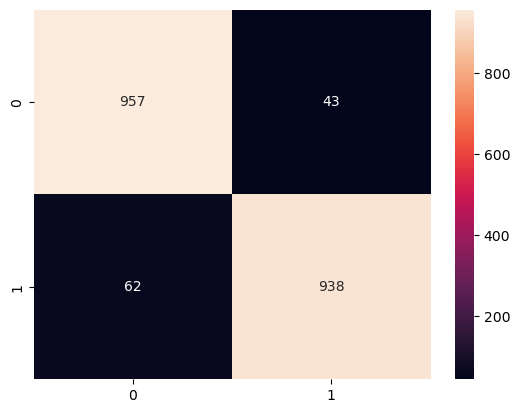

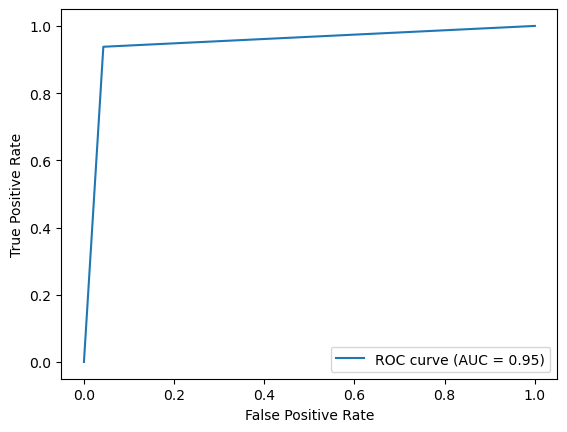

In [14]:
# Modelni yaratamiz (training)
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Modelni baholaymiz
y_pred = xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Model aniqligi:", accuracy_score(y_test,y_pred))

## confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()